# Introduction
This Jupyter notebook contains the expirements for Massively Parallel Algorithms to study the behavior of Affinity Clustering.

In [3]:
import math
import random
from copy import deepcopy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy

import AffinityClustering as ACC

from datetime import datetime

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KDTree

from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext

## Data preparation

In [4]:
from numpy import random

from kees.DataModifier import DataModifier

def create_distance_matrix_simplified(V):
    rng = np.random.default_rng()
    s = len(V)
    # U = rng.choice(V, size=s)
    d_matrix = scipy.spatial.distance_matrix(V, V, threshold=1_000_000)
    E = {}
    max_weight = 0
    size = 0

    # create the edges in the dictionary
    for i in range(len(d_matrix)):
        dict2 = {}
        for j in range(len(d_matrix)):
            if i != j:
                size += 1
                max_weight = max(d_matrix[i][j], max_weight)
                dict2[j] = d_matrix[i][j]
        E[i] = dict2

    return E, size, max_weight

def make_blobs_with_pair_wise_edges(n_samples = 100, gauss = False, cluster = False):
    """
    Creates the distance matrix for the make_blobs dataset with only vertices. Also adds the edges to a dict.
    Returns the vertices, distance matrix, cluster labels of the blobs, total number of edges, and the maximum weight
    :return: distance matrix, a dict of all edges and the total number of edges.
    """
    V, y = make_blobs(n_samples = n_samples, centers = 3, n_features = 2, random_state = 56)
    dm = DataModifier()
    V = list(V)
    if gauss:
        V, n = dm.add_gaussian_noise(V, noise = 0.1)
    if cluster:
        V, n = dm.add_clustered_noise(V, type = 'circle', noise = 0.1)

    # generate a matrix of pairwise distances between ALL vertices.
    E, size, max_weight = create_distance_matrix_simplified(V)

    return V, E, y, size, max_weight
    

In [ ]:
n_samples = 1000
V, E, y, size, max_weight = make_blobs_with_pair_wise_edges(n_samples, False, False)
V = np.array(V)

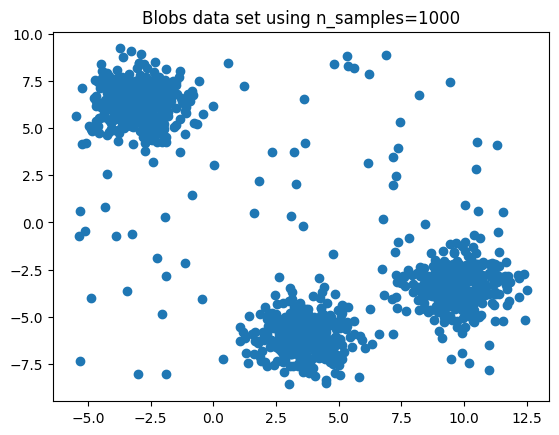

In [6]:
plt.scatter(V[:, 0], V[:, 1])
plt.title(f"Blobs data set using n_samples={n_samples}")
plt.savefig('blobs output.png')
(xmin, xmax) = plt.gca().get_xlim()
(ymin, ymax) = plt.gca().get_ylim()

##  Affinity clustering

In [48]:
def get_nearest_neighbours(V, k=5, leaf_size=2, buckets=False):
    def get_sort_key(item):
        return item[1]

    V_copy = deepcopy(V)
    if buckets:
        adj = []
        for key in V:
            nu = []
            sorted_list = sorted(V_copy[key].items(), key=get_sort_key)
            last = -1
            to_shuffle = []
            for i in range(k):
                if last != sorted_list[i][1]:
                    to_shuffle.append((sorted_list[i][0], sorted_list[i][1]))
                    random.shuffle(to_shuffle)
                    for item in to_shuffle:
                        nu.append(item)
                    to_shuffle = []
                else:
                    to_shuffle.append((sorted_list[i][0], sorted_list[i][1]))
                last = sorted_list[i][1]

            random.shuffle(to_shuffle)
            for item in to_shuffle:
                nu.append(item)
            adj.append((key, nu))
    else:
        kd_tree = KDTree(V, leaf_size=leaf_size)
        dist, ind = kd_tree.query(V, k=k + 1)

        adj = []
        for i in range(len(V)):
            nu = [(ind[i, j], dist[i, j]) for j in range(1, len(dist[i]))]
            adj.append((i, nu))

    return adj

In [49]:
def create_buckets(E, alpha, beta, W):
    num_buckets = math.ceil(math.log(W, (1 + beta)))
    buckets = []
    prev_end = 0
    for i in range(num_buckets):
        now_end = np.power((1 + beta), i) + (np.random.uniform(-alpha, alpha) * np.power((1 + beta), i))
        if i < num_buckets - 1:
            buckets.append((prev_end, now_end))
            prev_end = now_end
        else:
            buckets.append((prev_end, W + 0.00001))

    bucket_counter = [0] * len(buckets)

    for key in E:
        for edge in E[key]:
            bucket_number = 1
            for bucket in buckets:
                if bucket[0] <= E[key][edge] < bucket[1]:
                    E[key][edge] = bucket_number
                    bucket_counter[bucket_number - 1] += 1
                    break
                bucket_number += 1
    return E, buckets, bucket_counter

In [50]:
def shift_edge_weights(E, gamma=0.05):
    max_weight = 0
    for key in E:
        for edge in E[key]:
            # TODO: fix shift (remove 100 *)
            if key < edge:
                E[key][edge] = 100 * max(E[key][edge] + (np.random.uniform(-gamma, gamma)) * E[key][edge], 0)
                max_weight = max(E[key][edge], max_weight)
            else:
                E[key][edge] = E[edge][key]
    return E, max_weight

In [51]:
def find_best_neighbours(adj):
    u, nu = adj
    nn = u
    if len(nu) > 0:
        min_v, min_w = nu[0]
        for v, w in nu:
            if w < min_w:
                min_v, min_w = v, w
        nn = min_v
    return u, nn


def find_leader(_lambda):
    def find(adj):
        u, nu = adj
        c, v = u, u
        S = []
        cnt = 0
        while v not in S:
            S.append(v)
            v = _lambda[v]
            cnt += 1
            c = min(c, v)
        return u, c

    return find

In [52]:
def map_contract_graph(_lambda, leader):
    def contraction(adj):
        u, nu = adj
        c, v = u, u
        S = []
        while v not in S:
            S.append(v)
            c = min(c, v)
            v = _lambda[v]
        c = min(c, v)
        A = list(filter(lambda e: leader[e[0]] != c, nu))
        return c, A
    return contraction


def reduce_contract_graph(leader):
    def reduce_contraction(Nu, A):
        for v, w in A:
            l = leader[v]
            new = True
            for i, e in enumerate(Nu):
                if l == e[0]:
                    new = False
                    Nu[i] = (l, min(w, e[1]))
            if new:
                Nu.append((l, w))
        return Nu
    return reduce_contraction

In [53]:
def affinity_clustering(adj, vertex_coordinates, plot_intermediate, num_clusters=3):
    conf = SparkConf().setAppName('MST_Algorithm')
    sc = SparkContext.getOrCreate(conf=conf)
    clusters = [[i] for i in range(len(adj))]
    yhats = []
    leaders = []
    graph = deepcopy(adj)
    rdd = sc.parallelize(adj)

    i = 0
    imax = 40
    contracted_leader = [None] * len(adj)
    mst = [None] * len(adj)
    while i < imax:
        if len(graph) <= num_clusters:
            break
        num_edges = sum(map(lambda v: len(v[1]), graph))
        if num_edges == 0:
            break

        rdd1 = rdd.map(find_best_neighbours).collect()
        _lambda = [None] * len(adj)
        for line in rdd1:
            _lambda[line[0]] = line[1]

        # Find leader
        leader = [None] * len(adj)
        rdd1 = rdd.map(find_leader(_lambda)).collect()
        for line in rdd1:
            leader[line[0]] = line[1]
        leaders.append(leader)

        for j in range(len(adj)):
            l = leader[j]
            if l is not None and not l == j:
                clusters[l].extend(clusters[j])
                clusters[j].clear()

        yhat = [None] * len(adj)
        for c, cluster in enumerate(clusters):
            for v in cluster:
                yhat[v] = c
        yhats.append(yhat)

        for j in range(len(adj)):
            if contracted_leader[j] is None:
                if yhat[j] != j:
                    contracted_leader[j] = yhat[j]
                    mst[j] = _lambda[j]

        # Contraction
        rdd = (rdd.map(map_contract_graph(_lambda=_lambda, leader=leader))
               .foldByKey([], reduce_contract_graph(leader)))
        # rdd = rdd.map(map_contract_graph(_lambda=_lambda, leader=leader)).reduceByKey(reduce_contract_graph(leader))

        graph = rdd.collect()

        i += 1

    for j in range(len(adj)):
        if contracted_leader[j] is None:
            contracted_leader[j] = yhat[j]
            mst[j] = yhat[j]

    return i, graph, yhats, contracted_leader, mst


In [54]:
def run(V, k, beta=0.0, alpha=0.0, gamma=0.0, buckets=False):
    if buckets:
        E, size, W = create_distance_matrix_simplified(V, full_dm=True)
        vertex_coordinates = V
        E, W = shift_edge_weights(E, gamma)
        # E, buckets, counter = create_buckets(E, alpha, beta, W)
        adjacency_list = get_nearest_neighbours(E, k, buckets=True)
    else:
        adjacency_list = get_nearest_neighbours(V, k)
    return affinity_clustering(adjacency_list, vertex_coordinates=None, plot_intermediate=False)

In [55]:
from kees.Plotter import *

# Parameters
beta = 0.2  # 0 <= beta <= 1 (buckets)
alpha = 0.1  # shift of buckets
gamma = 0.05  # shift of edge weights
buckets = False

file_location = 'Results/'
plotter = Plotter(None, None, file_location)
plotter.set_dataset("blobsnoise")
plotter.update_string()
plotter.reset_round()
runs_list, graph_list, yhats_list, contracted_leader_list, msts = [], [], [], [], []
for i in range(10):
    runs, graph, yhats, contracted_leader, mst = run(V, len(V) - 1, beta, alpha, gamma, buckets=buckets)
    runs_list.append(runs)
    graph_list.append(graph)
    yhats_list.append(yhats),
    contracted_leader_list.append(contracted_leader)
    msts.append(mst)
    plotter.plot_cluster(yhats[runs - 1], mst, V)
    plotter.next_round()
    print('Graph size: ', len(graph), graph)
    print('Runs: ', runs)
    print('yhats: ', yhats[runs - 1])

Graph size:  3 [(0, [(6, np.float64(0.45298434301684043)), (3, np.float64(0.6232649331304624))]), (3, [(6, np.float64(0.3700222902841548)), (0, np.float64(0.6232649331304624))]), (6, [(3, np.float64(0.3700222902841548)), (0, np.float64(0.45298434301684043))])]
Runs:  9
yhats:  [0, 0, 0, 3, 0, 0, 6, 0, 6, 0, 0, 0, 6, 0, 0, 6, 6, 6, 6, 6, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 0, 6, 0, 0, 0, 6, 0, 0, 6, 6, 3, 0, 0, 6, 0, 0, 0, 0, 0, 0, 6, 0, 6, 6, 0, 6, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 6, 6, 0, 0, 0, 6, 6, 6, 6, 0, 0, 6, 0, 6, 6, 6, 6, 6, 0, 6, 0, 6, 6, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 6, 0, 0, 6, 0, 0, 6, 0, 0, 0, 6, 0, 6, 0, 0, 6, 6, 0, 0, 6, 0, 0, 6, 0, 0, 0, 0, 0, 0, 6, 0, 6, 6, 6, 0, 0, 6, 0, 6, 6, 0, 6, 0, 0, 6, 0, 0, 6, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 6, 6, 6, 0, 0, 6, 0, 0, 0, 0, 0, 0, 6, 0, 6, 0, 6, 0, 0, 6, 0, 6, 0, 0, 0, 6, 6, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 6, 0, 0, 6, 0, 0, 6, 0, 0, 6, 0, 0, 0, 0, 0, 6, 6, 0, 6

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "c:\Users\mario\sources\repos\mpa\mpa\Lib\site-packages\py4j\java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\mario\sources\repos\mpa\mpa\Lib\site-packages\py4j\clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\socket.py", line 706, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

# K-Means Clustering

In [7]:
from scipy.spatial import Voronoi

clusteringAlgo = KMeans(n_clusters=3, random_state=56)
yhat = clusteringAlgo.fit(V)

In [8]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all([v >= 0 for v in vertices]):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)


In [9]:
def generate_plot(centers, title):
    # compute Voronoi tesselation
    vor = Voronoi(centers)

    # plot
    regions, vertices = voronoi_finite_polygons_2d(vor, radius = 150)

    # colorize
    for region in regions:
        polygon = vertices[region]
        plt.fill(*zip(*polygon), alpha=0.4)

    plt.plot(centers[:,0], centers[:,1], 'ko')
    # plt.axis('equal')
    plt.scatter(*zip(*V), c='r')

    plt.xlim([xmin, xmax])
    plt.ylim([ymin, ymax])
    plt.title(title)
    plt.savefig(f'{title}.png')

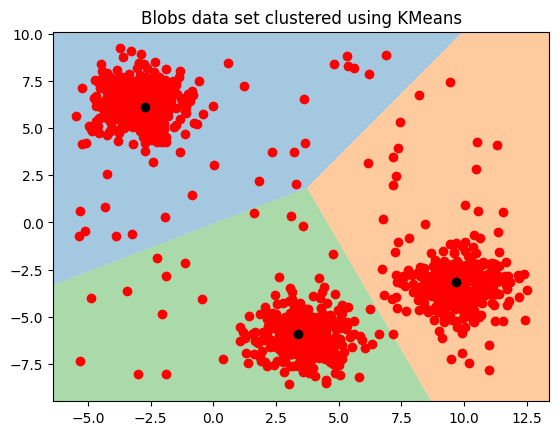

In [10]:
centers=clusteringAlgo.cluster_centers_
generate_plot(centers, f'Blobs data set clustered using KMeans')


In [11]:
from sklearn.cluster import AffinityPropagation


affinity_propagation = AffinityPropagation(damping=.9, preference=-200, random_state=56)
yhat = affinity_propagation.fit(V)

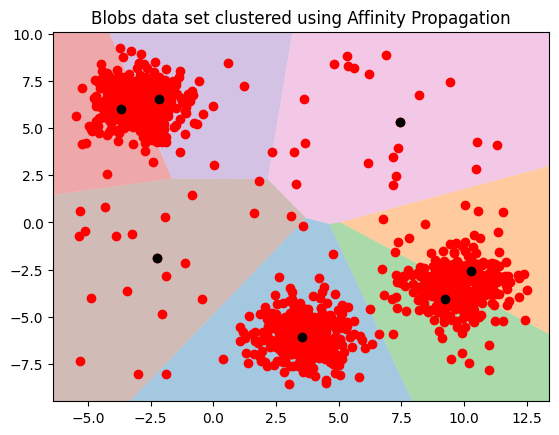

In [12]:
centers = yhat.cluster_centers_
generate_plot(centers, f'Blobs data set clustered using Affinity Propagation')

In [13]:
n_samples = 1000
V, E, y, size, max_weight = make_blobs_with_pair_wise_edges(n_samples, True, False)
V = np.array(V)

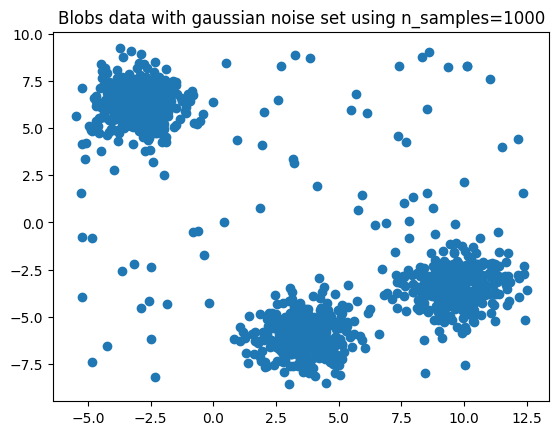

In [14]:
plt.scatter(V[:, 0], V[:, 1])
plt.title(f"Blobs data with gaussian noise set using n_samples={n_samples}")
plt.savefig('blobs output gaussian noise.png')
(xmin, xmax) = plt.gca().get_xlim()
(ymin, ymax) = plt.gca().get_ylim()

In [16]:
clusteringAlgo = KMeans(n_clusters=3, random_state=56)
yhat = clusteringAlgo.fit(V)

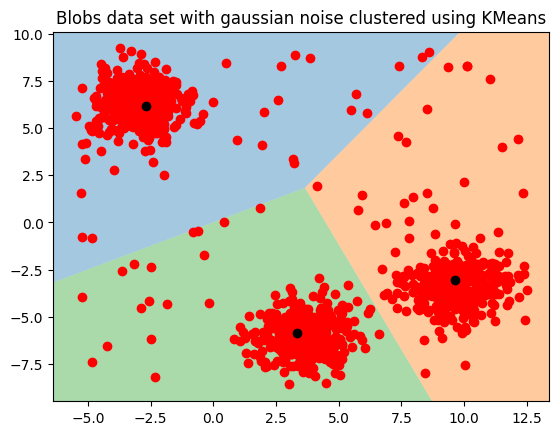

In [17]:
centers=clusteringAlgo.cluster_centers_
generate_plot(centers, f'Blobs data set with gaussian noise clustered using KMeans')

In [18]:
affinity_propagation = AffinityPropagation(damping=.9, preference=-200, random_state=56)
yhat = affinity_propagation.fit(V)

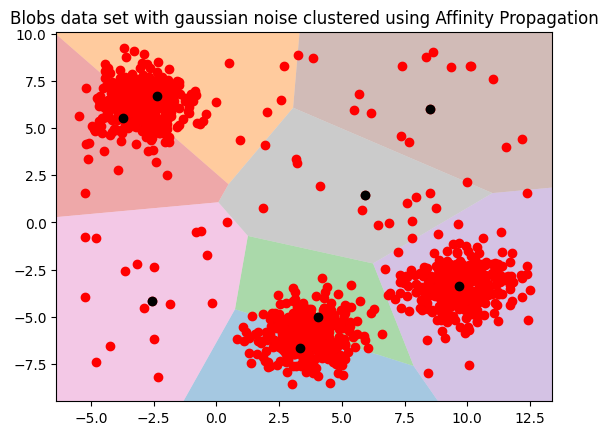

In [19]:
centers = yhat.cluster_centers_
generate_plot(centers, f'Blobs data set with gaussian noise clustered using Affinity Propagation')